In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import pandas as pd
import scipy.sparse as sps
import yaml
from itertools import chain, product, combinations
import torch

from time import time as tt
from tqdm import tqdm

from gnn4itk_cf.core.infer_stage import infer
from gnn4itk_cf.core.eval_stage import evaluate

from gnn4itk_cf.stages.data_reading.models.trackml_utils import *

from gnn4itk_cf.stages.data_reading.data_reading_stage import EventReader
from gnn4itk_cf.stages.data_reading.models.trackml_reader import TrackMLReader

from gnn4itk_cf.stages.graph_construction.models.metric_learning import MetricLearning
from gnn4itk_cf.stages.edge_classifier.models.filter import Filter
from gnn4itk_cf.stages.edge_classifier import InteractionGNN

from gnn4itk_cf.stages.graph_construction.utils import handle_weighting
from gnn4itk_cf.stages.graph_construction.models.utils import graph_intersection, build_edges
from gnn4itk_cf.stages.graph_construction.utils import *

from gnn4itk_cf.stages.track_building import utils 
from torch_geometric.utils import to_scipy_sparse_matrix

import gnn4itk_cf
print(gnn4itk_cf.core.eval_stage.__file__)

/global/homes/a/alazar/.conda/envs/gnn4itk/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FRNN is available
/global/u2/a/alazar/acorn/gnn4itk_cf/core/eval_stage.py


In [2]:
config_dr = "../examples/Example_1/data_reader.yaml"
config_mm = "../examples/Example_1/module_map_infer.yaml"
config_gnn = "../examples/Example_1/gnn_infer.yaml"
config_tbi = "../examples/Example_1/track_building_infer.yaml"
config_tbe = "../examples/Example_1/track_building_eval.yaml"

100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Number of reconstructed particles: 14514
Number of particles: 16081
Number of matched tracks: 17430
Number of tracks: 17528
Number of duplicate reconstructed particles: 2905
Efficiency: 0.903
Fake rate: 0.006
Duplication rate: 0.200


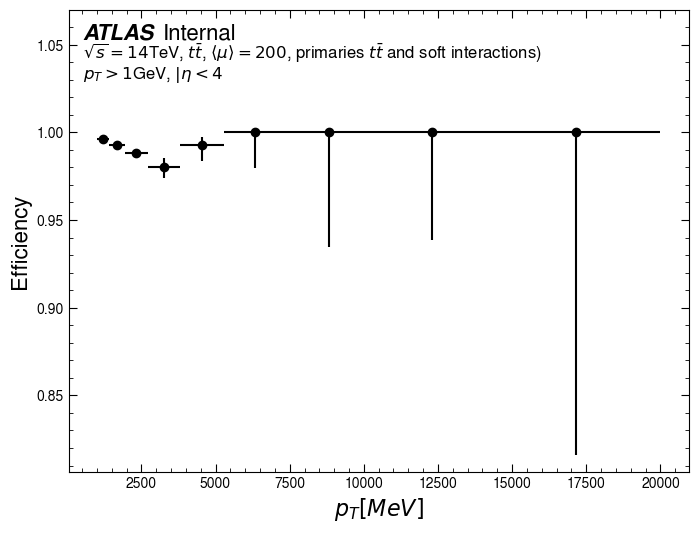

In [3]:
#infer(config_dr )
#infer(config_mm)
#infer(config_gnn)
#infer(config_tbi)
evaluate(config_tbe,None)

In [4]:
with open("../examples/Example_2/metric_learning_train.yaml", "r") as f:
    config_ml = yaml.load(f, Loader=yaml.FullLoader)
model_ml = MetricLearning(config_ml)
with open("../examples/Example_1/gnn_train.yaml", "r") as f:
    config_gnn = yaml.load(f, Loader=yaml.FullLoader)
model_gnn = InteractionGNN(config_gnn)
config_tb = yaml.safe_load(open("../examples/Example_1/track_building_eval.yaml", "r"))
print(config_gnn['stage_dir']+'artifacts')

/pscratch/sd/a/alazar/cf/Example_1/gnn/artifacts


In [5]:
model_ml.setup(stage="predict")
dataloaders = model_ml.predict_dataloader()
model_ml = model_ml.load_from_checkpoint(config_ml['stage_dir']+'artifacts/best.ckpt')
model_gnn.setup('predict')
dataloaders = model_gnn.predict_dataloader()
model_gnn = model_gnn.load_from_checkpoint(config_gnn['stage_dir']+'artifacts/best.ckpt')
dataloaders

Loaded 80 training events, 10 validation events and 10 testing events


/global/u2/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [pid] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [n_hits] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [primary] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [pdg_id] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [ghost] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78:

Defining figures of merit


/global/u2/a/alazar/acorn/gnn4itk_cf/stages/edge_classifier/edge_classifier_stage.py:94: UserWarning: Failed to define figures of merit, due to logger unavailable
  warnings.warn(


In [6]:
def evaluate_labelled_graphs(graphset, config):
    all_y_truth, all_pt  = [], []
    evaluated_events = [
        utils.evaluate_labelled_graph(
            event,
            matching_fraction=config["matching_fraction"],
            matching_style=config["matching_style"],
            min_track_length=config["min_track_length"],
            min_particle_length=config["min_particle_length"],
        )
        for event in tqdm(graphset)
    ]
    evaluated_events = pd.concat(evaluated_events)

    particles = evaluated_events[evaluated_events["is_reconstructable"]]
    reconstructed_particles = particles[particles["is_reconstructed"] & particles["is_matchable"]]
    tracks = evaluated_events[evaluated_events["is_matchable"]]
    matched_tracks = tracks[tracks["is_matched"]]

    n_particles = len(particles.drop_duplicates(subset=['event_id', 'particle_id']))
    n_reconstructed_particles = len(reconstructed_particles.drop_duplicates(subset=['event_id', 'particle_id']))

    n_tracks = len(tracks.drop_duplicates(subset=['event_id', 'track_id']))
    n_matched_tracks = len(matched_tracks.drop_duplicates(subset=['event_id', 'track_id']))

    n_dup_reconstructed_particles = len(reconstructed_particles) - n_reconstructed_particles

    print(f"Number of reconstructed particles: {n_reconstructed_particles}")
    print(f"Number of particles: {n_particles}")
    print(f"Number of matched tracks: {n_matched_tracks}")
    print(f"Number of tracks: {n_tracks}")
    print(f"Number of duplicate reconstructed particles: {n_dup_reconstructed_particles}")   

    # Plot the results across pT and eta
    eff = n_reconstructed_particles / n_particles
    fake_rate = 1 - (n_matched_tracks / n_tracks)
    dup_rate = n_dup_reconstructed_particles / n_reconstructed_particles

    logging.info(f"Efficiency: {eff:.3f}")
    logging.info(f"Fake rate: {fake_rate:.3f}")
    logging.info(f"Duplication rate: {dup_rate:.3f}")
    print(f"Efficiency: {eff:.3f}")
    print(f"Fake rate: {fake_rate:.3f}")
    print(f"Duplication rate: {dup_rate:.3f}")

In [ ]:
#     with torch.no_grad():
#         if device == 'cuda':
#             with torch.cuda.amp.autocast():
#                 embedding = model_ml.apply_embedding(batch)
     
#     batch.edge_index = build_edges(
#         query=embedding, database=embedding, indices=None, r_max=0.1, k_max=10, backend="FRNN"
#     )
#     R = batch.r**2 + batch.z**2
#     flip_edge_mask = R[batch.edge_index[0]] > R[batch.edge_index[1]]
#     batch.edge_index[:, flip_edge_mask] = batch.edge_index[:, flip_edge_mask].flip(0)

In [11]:
device ='cuda'
model_ml = model_ml.to("cuda")
model_gnn = model_gnn.to("cuda")
graphs = []
for batch_idx, batch in enumerate(dataloaders[2]):
    batch = batch.to("cuda")    
    gnn = model_gnn.shared_evaluation(batch,batch_idx)
    batch = gnn['batch']
    batch.truth_map = graph_intersection(
            batch.edge_index,
            batch.track_edges,
            return_y_pred=False,
            return_y_truth=False,
            return_truth_to_pred=True,
        )
    edge_mask = gnn['output'] > model_gnn.hparams['edge_cut'] 
    # Get number of nodes
    if hasattr(batch, "num_nodes"):
        num_nodes = batch.num_nodes
    elif hasattr(batch, "x"):
        num_nodes = batch.x.size(0)
    elif hasattr(batch, "x_x"):
        num_nodes = batch.x_x.size(0)
    else:
        num_nodes = batch.edge_index.max().item() + 1
    # Convert to sparse scipy array
    sparse_edges = to_scipy_sparse_matrix(
        batch.edge_index[:, edge_mask], num_nodes=num_nodes
    )
    # Run connected components
    candidate_labels = sps.csgraph.connected_components(
        sparse_edges, directed=False, return_labels=True
    )
    batch.labels = torch.from_numpy(candidate_labels[1]).long()
    graphs.append(batch.to('cpu'))
evaluate_labelled_graphs(graphs, config_tb)

100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


Number of reconstructed particles: 12430
Number of particles: 16081
Number of matched tracks: 12883
Number of tracks: 13675
Number of duplicate reconstructed particles: 445
Efficiency: 0.773
Fake rate: 0.058
Duplication rate: 0.036
